**Cấu hình**

In [1]:
import torch

device = torch.device('cuda')
root_dir = '/kaggle/input/dragon-fruit-and-leaf-dataset/oversample/Fruit'
root_dir = '/kaggle/input/dragon-fruit-and-leaf-dataset/oversample/Leaf'
batch = 32
lr = 1e-4
wd = 1e-4
pth = '/kaggle/working/model_save'

**Các labels có trong dataset**

In [2]:
# Kiểm tra các folder trong dataset
import os

print("=== KIỂM TRA DATASET STRUCTURE ===")
print(f"Dataset path: {root_dir}")

# Liệt kê tất cả các folder
all_items = os.listdir(root_dir)
print(f"\nTất cả items trong folder: {len(all_items)}")
for i, item in enumerate(all_items, 1):
    item_path = os.path.join(root_dir, item)
    is_dir = os.path.isdir(item_path)
    print(f"{i}. {item} {'(folder)' if is_dir else '(file)'}")

# Chỉ lấy các folder thật sự
valid_folders = []
for item in all_items:
    item_path = os.path.join(root_dir, item)
    if os.path.isdir(item_path) and not item.startswith('.'):
        # Kiểm tra xem folder có chứa ảnh không
        image_files = []
        try:
            for file in os.listdir(item_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    image_files.append(file)
            
            if len(image_files) > 0:
                valid_folders.append(item)
                print(f"✓ {item}: {len(image_files)} images")
            else:
                print(f"✗ {item}: No images found")
        except:
            print(f"✗ {item}: Cannot access folder")

print(f"\nValid classes found: {len(valid_folders)}")
print(f"Classes: {valid_folders}")

if len(valid_folders) != 10:
    print(f"\n  WARNING: Expected 6 classes but found {len(valid_folders)} classes!")
    print("This might cause issues with the model.")
else:
    print("\n Dataset structure looks correct (6 classes)")

=== KIỂM TRA DATASET STRUCTURE ===
Dataset path: /kaggle/input/dragon-fruit-and-leaf-dataset/oversample/Leaf

Tất cả items trong folder: 10
1. White Spot (folder)
2. Root Rot (folder)
3. Black Spot (folder)
4. Stem_Canker (folder)
5. Anthracnose (folder)
6. Healthy (folder)
7. Stem Rot (folder)
8. Brown Spot (folder)
9. Twig Blight (folder)
10. Soft Rot (folder)
✓ White Spot: 244 images
✓ Root Rot: 276 images
✓ Black Spot: 240 images
✓ Stem_Canker: 103 images
✓ Anthracnose: 118 images
✓ Healthy: 372 images
✓ Stem Rot: 296 images
✓ Brown Spot: 324 images
✓ Twig Blight: 200 images
✓ Soft Rot: 200 images

Valid classes found: 10
Classes: ['White Spot', 'Root Rot', 'Black Spot', 'Stem_Canker', 'Anthracnose', 'Healthy', 'Stem Rot', 'Brown Spot', 'Twig Blight', 'Soft Rot']

 Dataset structure looks correct (6 classes)


**Tăng cường và Tải dữ liệu lên**

In [3]:
import cv2
import numpy as np
import os
from glob import glob
import sys  
import shutil

def preprocess_outdoor_image(image_path):
    """
    Xử lý ảnh outdoor với CLAHE và sharpening
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Cannot read image {image_path}")
            return None
            
        img = cv2.resize(img, (224, 224))
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0)
        cl = clahe.apply(l)
        img = cv2.merge((cl, a, b))
        img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
        blur = cv2.GaussianBlur(img, (5, 5), 1.0)
        img = cv2.addWeighted(img, 1.5, blur, -0.5, 0)
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0
        return (img * 255).astype(np.uint8)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_dataset(input_dir, output_dir):
    """
    Xử lý toàn bộ dataset với validation
    """
    print("=== PROCESSING DATASET ===")
    
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    total_processed = 0
    total_failed = 0
    
    for cls in os.listdir(input_dir):
        input_cls_path = os.path.join(input_dir, cls)
        
        if not os.path.isdir(input_cls_path):
            continue
            
        output_cls_path = os.path.join(output_dir, cls)
        os.makedirs(output_cls_path, exist_ok=True)
        
        # Lấy tất cả file ảnh
        img_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            img_files.extend(glob(os.path.join(input_cls_path, ext)))
            img_files.extend(glob(os.path.join(input_cls_path, ext.upper())))
        
        total = len(img_files)
        processed = 0
        failed = 0
        
        print(f"\nProcessing class {cls}: {total} images")
        
        for idx, img_file in enumerate(img_files, 1):
            percent = idx / total * 100
            print(f'\r  Progress: {percent:.1f}% ({idx}/{total})', end='')
            sys.stdout.flush()
            
            img_processed = preprocess_outdoor_image(img_file)
            if img_processed is not None:
                filename = os.path.basename(img_file)
                # Đảm bảo extension là .jpg
                name, _ = os.path.splitext(filename)
                output_path = os.path.join(output_cls_path, f"{name}.jpg")
                cv2.imwrite(output_path, img_processed)
                processed += 1
            else:
                failed += 1
        
        print(f"\n  ✓ Processed: {processed}, ✗ Failed: {failed}")
        total_processed += processed
        total_failed += failed
    
    print(f"\n=== PROCESSING COMPLETE ===")
    print(f"Total processed: {total_processed}")
    print(f"Total failed: {total_failed}")
    print(f"Success rate: {total_processed/(total_processed+total_failed)*100:.1f}%")
    
    return output_dir

# Xử lý dataset
data_dir = root_dir
output_dir = '/kaggle/working/processed_dragonfruit'
processed_output_dir = process_dataset(data_dir, output_dir)

print(f"\nFinal processed dataset path: {processed_output_dir}")

=== PROCESSING DATASET ===

Processing class White Spot: 244 images
  Progress: 100.0% (244/244)
  ✓ Processed: 244, ✗ Failed: 0

Processing class Root Rot: 276 images
  Progress: 100.0% (276/276)
  ✓ Processed: 276, ✗ Failed: 0

Processing class Black Spot: 240 images
  Progress: 100.0% (240/240)
  ✓ Processed: 240, ✗ Failed: 0

Processing class Stem_Canker: 103 images
  Progress: 100.0% (103/103)
  ✓ Processed: 103, ✗ Failed: 0

Processing class Anthracnose: 118 images
  Progress: 100.0% (118/118)
  ✓ Processed: 118, ✗ Failed: 0

Processing class Healthy: 372 images
  Progress: 100.0% (372/372)
  ✓ Processed: 372, ✗ Failed: 0

Processing class Stem Rot: 296 images
  Progress: 100.0% (296/296)
  ✓ Processed: 296, ✗ Failed: 0

Processing class Brown Spot: 324 images
  Progress: 100.0% (324/324)
  ✓ Processed: 324, ✗ Failed: 0

Processing class Twig Blight: 200 images
  Progress: 100.0% (200/200)
  ✓ Processed: 200, ✗ Failed: 0

Processing class Soft Rot: 200 images
  Progress: 100.0% (

**Tăng cường dữ liệu cho các class có ít mẫu**

In [4]:
import cv2
import numpy as np
import os
from glob import glob
import random
import shutil
from collections import Counter

def advanced_augmentation(image, augmentation_type):
    """
    Áp dụng các kỹ thuật augmentation nâng cao
    """
    if augmentation_type == 'rotate_15':
        rows, cols = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
        return cv2.warpAffine(image, M, (cols, rows))
    
    elif augmentation_type == 'rotate_345':
        rows, cols = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), -15, 1)
        return cv2.warpAffine(image, M, (cols, rows))
    
    elif augmentation_type == 'brightness_up':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:,:,2] = cv2.add(hsv[:,:,2], 30)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    elif augmentation_type == 'brightness_down':
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:,:,2] = cv2.subtract(hsv[:,:,2], 30)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    elif augmentation_type == 'contrast_up':
        return cv2.convertScaleAbs(image, alpha=1.3, beta=0)
    
    elif augmentation_type == 'contrast_down':
        return cv2.convertScaleAbs(image, alpha=0.7, beta=0)
    
    elif augmentation_type == 'flip_horizontal':
        return cv2.flip(image, 1)
    
    elif augmentation_type == 'flip_vertical':
        return cv2.flip(image, 0)
    
    elif augmentation_type == 'zoom_in':
        rows, cols = image.shape[:2]
        # Zoom in 1.2x
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 0, 1.2)
        return cv2.warpAffine(image, M, (cols, rows))
    
    elif augmentation_type == 'zoom_out':
        rows, cols = image.shape[:2]
        # Zoom out 0.8x
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 0, 0.8)
        return cv2.warpAffine(image, M, (cols, rows))
    
    elif augmentation_type == 'shift_right':
        rows, cols = image.shape[:2]
        M = np.float32([[1, 0, 20], [0, 1, 0]])
        return cv2.warpAffine(image, M, (cols, rows))
    
    elif augmentation_type == 'shift_left':
        rows, cols = image.shape[:2]
        M = np.float32([[1, 0, -20], [0, 1, 0]])
        return cv2.warpAffine(image, M, (cols, rows))
    
    elif augmentation_type == 'noise':
        noise = np.random.randint(0, 25, image.shape, dtype=np.uint8)
        return cv2.add(image, noise)
    
    elif augmentation_type == 'blur':
        return cv2.GaussianBlur(image, (5, 5), 0)
    
    else:
        return image

def augment_dataset(input_dir, output_dir, target_samples_per_class=1000):
    """
    Tăng cường dữ liệu để đạt target_samples_per_class cho mỗi class
    """
    print("=== AUGMENTING DATASET ===")
    
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    
    # Danh sách các augmentation techniques
    augment_types = [
        'rotate_15', 'rotate_345', 'brightness_up', 'brightness_down',
        'contrast_up', 'contrast_down', 'flip_horizontal', 'flip_vertical',
        'zoom_in', 'zoom_out', 'shift_right', 'shift_left', 'noise', 'blur'
    ]
    
    class_stats = {}
    
    for cls in os.listdir(input_dir):
        input_cls_path = os.path.join(input_dir, cls)
        
        if not os.path.isdir(input_cls_path):
            continue
            
        output_cls_path = os.path.join(output_dir, cls)
        os.makedirs(output_cls_path, exist_ok=True)
        
        # Lấy tất cả file ảnh gốc
        img_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            img_files.extend(glob(os.path.join(input_cls_path, ext)))
            img_files.extend(glob(os.path.join(input_cls_path, ext.upper())))
        
        original_count = len(img_files)
        print(f"\nClass {cls}: {original_count} original images")
        
        # Copy ảnh gốc trước
        copied_count = 0
        for idx, img_file in enumerate(img_files):
            img = cv2.imread(img_file)
            if img is not None:
                filename = f"original_{idx:04d}.jpg"
                output_path = os.path.join(output_cls_path, filename)
                cv2.imwrite(output_path, img)
                copied_count += 1
        
        # Tính số ảnh cần tạo thêm
        needed_count = max(0, target_samples_per_class - copied_count)
        
        if needed_count > 0:
            print(f"  Need to generate {needed_count} additional images")
            
            # Tạo ảnh augmented
            generated_count = 0
            while generated_count < needed_count:
                # Chọn ngẫu nhiên một ảnh gốc
                source_img_path = random.choice(img_files)
                source_img = cv2.imread(source_img_path)
                
                if source_img is not None:
                    # Chọn ngẫu nhiên một augmentation technique
                    aug_type = random.choice(augment_types)
                    augmented_img = advanced_augmentation(source_img, aug_type)
                    
                    # Lưu ảnh đã augmented
                    filename = f"aug_{aug_type}_{generated_count:04d}.jpg"
                    output_path = os.path.join(output_cls_path, filename)
                    cv2.imwrite(output_path, augmented_img)
                    
                    generated_count += 1
                    
                    if generated_count % 100 == 0:
                        print(f"    Generated {generated_count}/{needed_count} images")
        
        # Kiểm tra kết quả cuối cùng
        final_count = len([f for f in os.listdir(output_cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_stats[cls] = {
            'original': original_count,
            'final': final_count,
            'generated': final_count - copied_count
        }
        
        print(f"  ✓ Final: {final_count} images (Generated: {final_count - copied_count})")
    
    # In summary
    print(f"\n{'='*80}")
    print(f"AUGMENTATION SUMMARY")
    print(f"{'='*80}")
    print(f"{'Class':<20} {'Original':<10} {'Generated':<12} {'Final':<10} {'Target':<10}")
    print("-" * 80)
    
    total_original = 0
    total_generated = 0
    total_final = 0
    
    for cls, stats in class_stats.items():
        print(f"{cls:<20} {stats['original']:<10} {stats['generated']:<12} {stats['final']:<10} {target_samples_per_class:<10}")
        total_original += stats['original']
        total_generated += stats['generated']
        total_final += stats['final']
    
    print("-" * 80)
    print(f"{'TOTAL':<20} {total_original:<10} {total_generated:<12} {total_final:<10} {len(class_stats) * target_samples_per_class:<10}")
    
    return output_dir, class_stats

# Thực hiện augmentation 
# Đặt target là 800 mẫu mỗi class (bạn có thể điều chỉnh số này)
augmented_data_dir = '/kaggle/working/augmented_dragonfruit'
target_samples = 300

print("Bắt đầu tăng cường dữ liệu...")
augmented_output_dir, augmentation_stats = augment_dataset(
    root_dir, 
    augmented_data_dir, 
    target_samples_per_class=target_samples
)

print(f"\nDữ liệu đã được tăng cường và lưu tại: {augmented_output_dir}")
print(f"Mỗi class hiện có khoảng {target_samples} mẫu")

Bắt đầu tăng cường dữ liệu...
=== AUGMENTING DATASET ===

Class White Spot: 244 original images
  Need to generate 56 additional images
  ✓ Final: 300 images (Generated: 56)

Class Root Rot: 276 original images
  Need to generate 24 additional images
  ✓ Final: 300 images (Generated: 24)

Class Black Spot: 240 original images
  Need to generate 60 additional images
  ✓ Final: 300 images (Generated: 60)

Class Stem_Canker: 103 original images
  Need to generate 197 additional images
    Generated 100/197 images
  ✓ Final: 300 images (Generated: 197)

Class Anthracnose: 118 original images
  Need to generate 182 additional images
    Generated 100/182 images
  ✓ Final: 300 images (Generated: 182)

Class Healthy: 372 original images
  ✓ Final: 372 images (Generated: 0)

Class Stem Rot: 296 original images
  Need to generate 4 additional images
  ✓ Final: 300 images (Generated: 4)

Class Brown Spot: 324 original images
  ✓ Final: 324 images (Generated: 0)

Class Twig Blight: 200 original i

In [5]:
# Sử dụng dữ liệu đã được tăng cường thay vì dữ liệu gốc
data_dir = augmented_output_dir  # Sử dụng dữ liệu đã augmented
output_dir = '/kaggle/working/processed_dragonfruit_augmented'
processed_output_dir = process_dataset(data_dir, output_dir)

print(f"\nFinal processed dataset path: {processed_output_dir}")
print("Dataset hiện tại đã được tăng cường với nhiều mẫu hơn cho mỗi class!")

=== PROCESSING DATASET ===

Processing class Root Rot: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class Soft Rot: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class White Spot: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class Healthy: 372 images
  Progress: 100.0% (372/372)
  ✓ Processed: 372, ✗ Failed: 0

Processing class Stem_Canker: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class Stem Rot: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class Twig Blight: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class Anthracnose: 300 images
  Progress: 100.0% (300/300)
  ✓ Processed: 300, ✗ Failed: 0

Processing class Brown Spot: 324 images
  Progress: 100.0% (324/324)
  ✓ Processed: 324, ✗ Failed: 0

Processing class Black Spot: 300 images
  Progress: 100.0% (

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import os
import random

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.95, 1.05)),  
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),  
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.8)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4860, 0.5331, 0.3375], 
                         std=[0.2487, 0.2287, 0.2422]),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0)  
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4860, 0.5331, 0.3375],
                         std=[0.2487, 0.2287, 0.2422])
])

# Load dataset và validation
print("=== LOADING DATASET ===")
full_dataset = ImageFolder(root=processed_output_dir)

print(f"Dataset loaded from: {processed_output_dir}")
print(f"Number of classes found: {len(full_dataset.classes)}")
print(f"Classes: {full_dataset.classes}")

# Kiểm tra số lượng classes
if len(full_dataset.classes) !=10:
    print(f"  ERROR: Expected 10 classes but found {len(full_dataset.classes)}!")
    print("Please check your dataset structure.")
    raise ValueError(f"Invalid number of classes: {len(full_dataset.classes)}")
else:
    print(" Dataset validation passed - exactly 10 classes found!")

total_size = len(full_dataset)

# Chia dataset thành 3 phần: train/val/test (70/15/15)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(f'\nDataset split:')
print(f'Total dataset size: {total_size}')
print(f'Train size: {train_size} ({train_size/total_size*100:.1f}%)')
print(f'Val size: {val_size} ({val_size/total_size*100:.1f}%)')
print(f'Test size: {test_size} ({test_size/total_size*100:.1f}%)')

# Tạo random split với seed cố định để có thể tái tạo
generator = torch.Generator().manual_seed(42)
train_dataset, temp_dataset = random_split(
    full_dataset, [train_size, val_size + test_size], 
    generator=generator
)
val_dataset, test_dataset = random_split(
    temp_dataset, [val_size, test_size],
    generator=generator
)

# Thiết lập transforms cho từng tập
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_val_transform
test_dataset.dataset.transform = test_val_transform

# Tạo DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

=== LOADING DATASET ===
Dataset loaded from: /kaggle/working/processed_dragonfruit_augmented
Number of classes found: 10
Classes: ['Anthracnose', 'Black Spot', 'Brown Spot', 'Healthy', 'Root Rot', 'Soft Rot', 'Stem Rot', 'Stem_Canker', 'Twig Blight', 'White Spot']
 Dataset validation passed - exactly 10 classes found!

Dataset split:
Total dataset size: 3096
Train size: 2167 (70.0%)
Val size: 464 (15.0%)
Test size: 465 (15.0%)


**Tính toán Class Weights để xử lý Class Imbalance**

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from collections import Counter

def get_class_distribution(dataset):
    """Tính phân phối classes trong dataset"""
    labels = []
    for _, label in dataset:
        labels.append(label)
    return Counter(labels)

def compute_dataset_class_weights(dataset, device):
    """Tính class weights cho dataset"""
    # Lấy tất cả labels từ training dataset
    train_labels = []
    for _, label in dataset:
        train_labels.append(label)
    
    # Tính class weights
    unique_classes = np.unique(train_labels)
    class_weights = compute_class_weight(
        'balanced', 
        classes=unique_classes, 
        y=train_labels
    )
    
    # Convert sang tensor
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    return class_weights_tensor, dict(zip(unique_classes, class_weights))

# Phân tích phân phối classes
print("=== PHÂN PHỐI CLASSES ===")
train_dist = get_class_distribution(train_dataset)
val_dist = get_class_distribution(val_dataset)
test_dist = get_class_distribution(test_dataset)

# In bảng tổng hợp số lượng mẫu cho từng class
print(f"\n{'='*90}")
print(f"BẢNG TỔNG HỢP SỐ LƯỢNG MẪU THEO CLASS")
print(f"{'='*90}")
print(f"{'Class':<20} {'Train':<15} {'Val':<15} {'Test':<15} {'Total':<15}")
print("-" * 90)

total_train = 0
total_val = 0  
total_test = 0

for class_idx in range(len(full_dataset.classes)):
    class_name = full_dataset.classes[class_idx]
    train_count = train_dist.get(class_idx, 0)
    val_count = val_dist.get(class_idx, 0)
    test_count = test_dist.get(class_idx, 0)
    total_count = train_count + val_count + test_count
    
    print(f"{class_name:<20} {train_count:<15} {val_count:<15} {test_count:<15} {total_count:<15}")
    
    total_train += train_count
    total_val += val_count
    total_test += test_count

print("-" * 90)
print(f"{'TỔNG CỘNG':<20} {total_train:<15} {total_val:<15} {total_test:<15} {total_train + total_val + total_test:<15}")

# In phần trăm cho từng tập
print(f"\n{'='*90}")
print(f"PHẦN TRĂM MẪU THEO CLASS")
print(f"{'='*90}")
print(f"{'Class':<20} {'Train %':<15} {'Val %':<15} {'Test %':<15}")
print("-" * 90)

for class_idx in range(len(full_dataset.classes)):
    class_name = full_dataset.classes[class_idx]
    train_count = train_dist.get(class_idx, 0)
    val_count = val_dist.get(class_idx, 0)
    test_count = test_dist.get(class_idx, 0)
    
    train_pct = (train_count / total_train * 100) if total_train > 0 else 0
    val_pct = (val_count / total_val * 100) if total_val > 0 else 0
    test_pct = (test_count / total_test * 100) if total_test > 0 else 0
    
    print(f"{class_name:<20} {train_pct:<15.1f} {val_pct:<15.1f} {test_pct:<15.1f}")

# Tính class weights
class_weights_tensor, class_weights_dict = compute_dataset_class_weights(train_dataset, device)

print(f"\n{'='*60}")
print(f"CLASS WEIGHTS (để xử lý class imbalance)")
print(f"{'='*60}")
print(f"{'Class':<20} {'Weight':<15} {'Explanation'}")
print("-" * 60)
for class_idx, weight in class_weights_dict.items():
    class_name = full_dataset.classes[class_idx]
    explanation = "Higher weight" if weight > 1.0 else "Lower weight" if weight < 1.0 else "Balanced"
    print(f"{class_name:<20} {weight:<15.4f} {explanation}")

print(f"\nClass weights tensor: {class_weights_tensor}")
print(f"Tổng số classes: {len(full_dataset.classes)}")

=== PHÂN PHỐI CLASSES ===

BẢNG TỔNG HỢP SỐ LƯỢNG MẪU THEO CLASS
Class                Train           Val             Test            Total          
------------------------------------------------------------------------------------------
Anthracnose          211             42              47              300            
Black Spot           210             48              42              300            
Brown Spot           223             49              52              324            
Healthy              262             55              55              372            
Root Rot             204             51              45              300            
Soft Rot             221             38              41              300            
Stem Rot             211             47              42              300            
Stem_Canker          203             44              53              300            
Twig Blight          200             51              49              300       

**Mean and Std**

In [8]:
# from tqdm import tqdm

# mean = torch.zeros(3)
# std = torch.zeros(3)
# total_images = 0

# for images, _ in tqdm(train_loader):
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, 3, -1)  
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     total_images += batch_samples

# mean /= total_images
# std /= total_images

# print(f"Mean: {mean}")
# print(f"Std: {std}")

**Hiển thị hình ảnh**

In [ ]:
import matplotlib.pyplot as plt
import torchvision

data_iter = iter(train_loader)
images, labels = next(data_iter)
num_images_to_show = 100
images = images[:num_images_to_show]
labels = labels[:num_images_to_show]
mean = torch.tensor([0.4860, 0.5331, 0.3375]).reshape(3, 1, 1)
std = torch.tensor([0.2487, 0.2287, 0.2422]).reshape(3, 1, 1)
images = images * std + mean
grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(20, 10))
plt.imshow(grid_img.permute(1, 2, 0)) 
plt.axis('off')
plt.title('50 Images from Train Loader')
plt.show()

# Model Architecture

## MobileNetV3 Custom

In [ ]:

import torch.nn as nn
import math

__all__ = ['mobilenetv3_large','mobilenetv3_small','mobilenetv3_small_option1', 'mobilenetv3_small_option2', 'mobilenetv3_small_option3']


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]
        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride,
                          (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                SELayer(hidden_dim) if use_se else nn.Identity(),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride,
                          (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=1000, width_mult=1.0, last_channel=None):
        super(MobileNetV3, self).__init__()
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        block = InvertedResidual

        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel

        self.features = nn.Sequential(*layers)
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # last_channel mặc định: small=1024, large=1280
        default_channel = {'large': 1280, 'small': 1024}[mode]
        if last_channel is None:
            output_channel = ( _make_divisible(default_channel * width_mult, 8) 
                               if width_mult > 1.0 else default_channel )
        else:
            output_channel = last_channel

        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

def mobilenetv3_large(num_classes=1000):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', num_classes=num_classes)


def mobilenetv3_small(num_classes=1000):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k, t, c, SE, HS, s 
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', num_classes=num_classes)

# ============================
# OPTION 1: width_mult
# ============================
def mobilenetv3_small_option1(num_classes=1000, width_mult=0.75):
    cfgs = [
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]
    return MobileNetV3(cfgs, mode='small', num_classes=num_classes, width_mult=width_mult)


# ============================
# OPTION 2: last_channel=512
# ============================
def mobilenetv3_small_option2(num_classes=1000):
    cfgs = [
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]
    return MobileNetV3(cfgs, mode='small', num_classes=num_classes, last_channel=512)


# ============================
# OPTION 3: chỉnh cfgs
# ============================
def mobilenetv3_small_option3(num_classes=1000):
    # Ví dụ: giảm depth (bỏ bớt 1 block 40, 1 block 96), giảm channels
    cfgs = [
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  32, 1, 1, 2],   # giảm từ 40 -> 32
        [5,    6,  32, 1, 1, 1],
        # bỏ bớt 1 block 40
        [5,    3,  48, 1, 1, 1],
        # bỏ bớt 1 block 48
        [5,    6,  80, 1, 1, 2],   # giảm từ 96 -> 80
        [5,    6,  80, 1, 1, 1],
        # bỏ bớt 1 block 96
    ]
    return MobileNetV3(cfgs, mode='small', num_classes=num_classes)


**Huấn luyện**

**Chiến lược dừng sớm**

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class EarlyStopping:
    def __init__(self, patience=3, delta=0, path=pth):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_loss = float('inf') 
        self.counter = 0  
        self.early_stop = False  

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)  
            print("\nSaved best model")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

**Hàm Loss tập trung**

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, weight=None):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha.gather(0, targets)
            focal_loss *= alpha_t
        return focal_loss.mean()

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
        
    def forward(self, inputs, targets):
        return F.cross_entropy(inputs, targets, weight=self.weight)

**Chiến lược Label Smoothing**

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.criterion = nn.KLDivLoss(reduction='batchmean')

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return self.criterion(pred, true_dist)

**Detailed Evaluation Functions**

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

def detailed_evaluation(model, data_loader, class_names, device, dataset_name="Dataset"):
    """
    Đánh giá chi tiết model với precision, recall, F1-score cho từng class
    """
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Tính toán metrics chi tiết
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    # Accuracy tổng thể
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    
    print(f"\n{'='*60}")
    print(f"DETAILED EVALUATION ON {dataset_name.upper()}")
    print(f"{'='*60}")
    print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"\nPer-Class Metrics:")
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<10}")
    
    # Macro và Weighted averages
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    precision_weighted = np.average(precision, weights=support)
    recall_weighted = np.average(recall, weights=support)
    f1_weighted = np.average(f1, weights=support)
    
    print("-" * 60)
    print(f"{'Macro Avg':<20} {precision_macro:<10.4f} {recall_macro:<10.4f} {f1_macro:<10.4f} {np.sum(support):<10}")
    print(f"{'Weighted Avg':<20} {precision_weighted:<10.4f} {recall_weighted:<10.4f} {f1_weighted:<10.4f} {np.sum(support):<10}")
    
    # Classification report từ sklearn
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }

def plot_confusion_matrix_detailed(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Vẽ confusion matrix với percentages và counts
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    
    # Tạo annotations với cả count và percentage
    annotations = []
    for i in range(cm.shape[0]):
        row = []
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percentage = cm_normalized[i, j] * 100
            row.append(f'{count}\n({percentage:.1f}%)')
        annotations.append(row)
    
    sns.heatmap(cm_normalized, 
                annot=annotations, 
                fmt='', 
                cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    
    plt.title(f'{title}\n(Numbers show count and percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return cm

**Huấn luyện**

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# model = mobilenetv3_small(num_classes=10).to(device)

# model = mobilenetv3_large(num_classes=6).to(device)

# Option 1: giảm width_mult
# model = mobilenetv3_small_option1(num_classes=6, width_mult=0.75).to(device)

# Option 2: giảm FC cuối còn 512
# model = mobilenetv3_small_option2(num_classes=6).to(device)

# Option 3: chỉnh cfgs thủ công
model = mobilenetv3_small_option3(num_classes=10).to(device)


def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_total_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"Tổng số tham số trong model: {count_total_params(model):,}")
print(f"Số lượng tham số đang học: {count_trainable_params(model):,}")

# Sử dụng weighted loss với class weights
print(f"\nSử dụng class weights: {class_weights_tensor}")
criterion = WeightedCrossEntropyLoss(weight=class_weights_tensor)
# Hoặc sử dụng FocalLoss với weights:
# criterion = FocalLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=400)
early_stopping = EarlyStopping(patience=5, delta=0.01, path=pth)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_acc_l, train_loss_l, val_acc_l, val_loss_l = [], [], [], []

    total_start_time = time.time()
    
    for epochs in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        t_loss = 0.
        t_correct, t_total = 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epochs+1}/{num_epochs}")
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()

            _, train_predict = torch.max(outputs.data, 1)
            t_correct += (train_predict == labels).sum().item()
            t_total += labels.size(0)

        train_loss = t_loss/len(train_loader)
        train_acc = t_correct/t_total * 100
        train_loss_l.append(train_loss)
        train_acc_l.append(train_acc)

        model.eval()
        v_loss = 0.
        v_correct, v_total = 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                v_loss += loss.item()

                _, v_predict = torch.max(outputs.data, 1)
                v_correct += (v_predict == labels).sum().item()
                v_total += labels.size(0)

        val_loss = v_loss/len(val_loader)
        val_acc = v_correct/v_total * 100
        val_loss_l.append(val_loss)
        val_acc_l.append(val_acc)
        epoch_time = time.time() - epoch_start_time

        print(f'{epochs+1}/{num_epochs}: t_acc: {train_acc: .2f}, t_loss: {train_loss: .2f}, v_acc: {val_acc: .2f}, v_loss: {val_loss: .2f}, time: {epoch_time:.2f}s')
        
        scheduler.step()
        
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epochs+1}")
            break

    total_time = time.time() - total_start_time
    print(f"Tổng thời gian huấn luyện: {total_time/60:.2f} phút")

    # Sử dụng model với best weights đã được lưu bởi EarlyStopping
    if os.path.exists(pth):
        model.load_state_dict(torch.load(pth))
        print("Loaded best model weights")
    
    return train_acc_l, train_loss_l, val_acc_l, val_loss_l

# Bắt đầu training
print("\n" + "="*60)
print("BẮT ĐẦU QUÁ TRÌNH TRAINING")
print("="*60)
print(f"Epochs: 100")
print(f"Learning rate: {lr}")
print(f"Weight decay: {wd}")
print(f"Batch size: {batch}")
print(f"Device: {device}")
print(f"Classes: {len(full_dataset.classes)}")
print("="*60)

train_acc_l, train_loss_l, val_acc_l, val_loss_l = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=100
)

print("\n" + "="*60)
print("TRAINING HOÀN THÀNH!")
print("="*60)
torch.save(model.state_dict(), pth)
print(f"Model đã được lưu tại: {pth}")

3/100: t_acc:  45.45, t_loss:  1.48, v_acc:  53.23, v_loss:  1.33, time: 33.58s

Saved best model


Epoch 4/100: 100%|██████████| 68/68 [00:27<00:00,  2.46it/s]


4/100: t_acc:  49.56, t_loss:  1.36, v_acc:  55.39, v_loss:  1.22, time: 33.24s

Saved best model


Epoch 5/100: 100%|██████████| 68/68 [00:27<00:00,  2.48it/s]


5/100: t_acc:  55.19, t_loss:  1.20, v_acc:  55.17, v_loss:  1.12, time: 32.98s

Saved best model


Epoch 6/100: 100%|██████████| 68/68 [00:27<00:00,  2.48it/s]


6/100: t_acc:  58.28, t_loss:  1.14, v_acc:  61.21, v_loss:  0.99, time: 32.99s

Saved best model


Epoch 7/100: 100%|██████████| 68/68 [00:27<00:00,  2.47it/s]


7/100: t_acc:  61.79, t_loss:  1.02, v_acc:  66.38, v_loss:  0.91, time: 33.16s

Saved best model


Epoch 8/100: 100%|██████████| 68/68 [00:27<00:00,  2.51it/s]


8/100: t_acc:  62.99, t_loss:  0.97, v_acc:  65.73, v_loss:  0.87, time: 32.83s

Saved best model


Epoch 9/100: 100%|██████████| 68/68 [00:28<00:00,  2.40it/s]


9/100: t_acc:  66.31, t_loss:  0.91, v_acc:  67.89, v_loss:  0.82, time: 34.02s

Saved best model


Epoch 10/100: 100%|██████████| 68/68 [00:28<00:00,  2.42it/s]


10/100: t_acc:  67.14, t_loss:  0.89, v_acc:  71.77, v_loss:  0.75, time: 33.84s

Saved best model


Epoch 11/100: 100%|██████████| 68/68 [00:28<00:00,  2.35it/s]


11/100: t_acc:  70.33, t_loss:  0.78, v_acc:  75.00, v_loss:  0.71, time: 34.72s

Saved best model


Epoch 12/100: 100%|██████████| 68/68 [00:27<00:00,  2.44it/s]


12/100: t_acc:  70.37, t_loss:  0.78, v_acc:  74.35, v_loss:  0.70, time: 33.75s


Epoch 13/100: 100%|██████████| 68/68 [00:28<00:00,  2.41it/s]


13/100: t_acc:  71.62, t_loss:  0.74, v_acc:  77.80, v_loss:  0.65, time: 33.91s

Saved best model


Epoch 14/100: 100%|██████████| 68/68 [00:28<00:00,  2.42it/s]


14/100: t_acc:  75.17, t_loss:  0.68, v_acc:  76.51, v_loss:  0.61, time: 33.89s

Saved best model


Epoch 15/100: 100%|██████████| 68/68 [00:28<00:00,  2.42it/s]


15/100: t_acc:  75.36, t_loss:  0.68, v_acc:  79.74, v_loss:  0.54, time: 33.75s

Saved best model


Epoch 16/100: 100%|██████████| 68/68 [00:26<00:00,  2.54it/s]


16/100: t_acc:  78.26, t_loss:  0.60, v_acc:  79.09, v_loss:  0.53, time: 32.31s


Epoch 17/100: 100%|██████████| 68/68 [00:26<00:00,  2.58it/s]


17/100: t_acc:  77.85, t_loss:  0.59, v_acc:  79.09, v_loss:  0.55, time: 31.65s


Epoch 18/100: 100%|██████████| 68/68 [00:26<00:00,  2.58it/s]


18/100: t_acc:  78.31, t_loss:  0.57, v_acc:  82.54, v_loss:  0.52, time: 31.73s

Saved best model


Epoch 19/100: 100%|██████████| 68/68 [00:26<00:00,  2.58it/s]


19/100: t_acc:  80.43, t_loss:  0.52, v_acc:  82.54, v_loss:  0.49, time: 31.64s

Saved best model


Epoch 20/100: 100%|██████████| 68/68 [00:26<00:00,  2.56it/s]


20/100: t_acc:  80.85, t_loss:  0.52, v_acc:  81.90, v_loss:  0.51, time: 31.91s


Epoch 21/100: 100%|██████████| 68/68 [00:26<00:00,  2.59it/s]


21/100: t_acc:  83.02, t_loss:  0.47, v_acc:  83.84, v_loss:  0.43, time: 31.72s

Saved best model


Epoch 22/100: 100%|██████████| 68/68 [00:26<00:00,  2.58it/s]


22/100: t_acc:  82.65, t_loss:  0.46, v_acc:  82.11, v_loss:  0.45, time: 31.66s


Epoch 23/100: 100%|██████████| 68/68 [00:27<00:00,  2.49it/s]


23/100: t_acc:  82.51, t_loss:  0.45, v_acc:  84.91, v_loss:  0.39, time: 32.85s

Saved best model


Epoch 24/100: 100%|██████████| 68/68 [00:27<00:00,  2.47it/s]


24/100: t_acc:  82.74, t_loss:  0.43, v_acc:  86.42, v_loss:  0.37, time: 33.10s

Saved best model


Epoch 25/100: 100%|██████████| 68/68 [00:27<00:00,  2.46it/s]


25/100: t_acc:  83.43, t_loss:  0.43, v_acc:  86.64, v_loss:  0.37, time: 33.22s


Epoch 26/100: 100%|██████████| 68/68 [00:27<00:00,  2.47it/s]


26/100: t_acc:  83.76, t_loss:  0.42, v_acc:  86.21, v_loss:  0.39, time: 33.13s


Epoch 27/100: 100%|██████████| 68/68 [00:27<00:00,  2.48it/s]


27/100: t_acc:  85.37, t_loss:  0.37, v_acc:  87.28, v_loss:  0.31, time: 33.15s

Saved best model


Epoch 28/100: 100%|██████████| 68/68 [00:27<00:00,  2.47it/s]


28/100: t_acc:  85.79, t_loss:  0.37, v_acc:  90.09, v_loss:  0.32, time: 33.18s


Epoch 29/100: 100%|██████████| 68/68 [00:27<00:00,  2.46it/s]


29/100: t_acc:  85.37, t_loss:  0.39, v_acc:  89.66, v_loss:  0.26, time: 33.40s

Saved best model


Epoch 30/100: 100%|██████████| 68/68 [00:28<00:00,  2.41it/s]


30/100: t_acc:  86.11, t_loss:  0.37, v_acc:  85.78, v_loss:  0.36, time: 33.86s


Epoch 31/100: 100%|██████████| 68/68 [00:27<00:00,  2.44it/s]


31/100: t_acc:  86.94, t_loss:  0.36, v_acc:  89.44, v_loss:  0.29, time: 33.22s


Epoch 32/100: 100%|██████████| 68/68 [00:27<00:00,  2.46it/s]


32/100: t_acc:  87.72, t_loss:  0.31, v_acc:  89.01, v_loss:  0.31, time: 33.29s


Epoch 33/100: 100%|██████████| 68/68 [00:28<00:00,  2.37it/s]


33/100: t_acc:  87.82, t_loss:  0.31, v_acc:  89.01, v_loss:  0.27, time: 34.51s


Epoch 34/100: 100%|██████████| 68/68 [00:28<00:00,  2.36it/s]


34/100: t_acc:  88.32, t_loss:  0.33, v_acc:  90.52, v_loss:  0.25, time: 34.55s

Saved best model


Epoch 35/100: 100%|██████████| 68/68 [00:28<00:00,  2.39it/s]


35/100: t_acc:  87.40, t_loss:  0.32, v_acc:  90.30, v_loss:  0.24, time: 33.96s

Saved best model


Epoch 36/100: 100%|██████████| 68/68 [00:28<00:00,  2.37it/s]


36/100: t_acc:  89.48, t_loss:  0.29, v_acc:  90.52, v_loss:  0.27, time: 34.51s


Epoch 37/100: 100%|██████████| 68/68 [00:28<00:00,  2.39it/s]


37/100: t_acc:  89.29, t_loss:  0.27, v_acc:  90.52, v_loss:  0.22, time: 34.26s

Saved best model


Epoch 38/100: 100%|██████████| 68/68 [00:28<00:00,  2.37it/s]


38/100: t_acc:  88.28, t_loss:  0.32, v_acc:  89.66, v_loss:  0.27, time: 34.53s


Epoch 43/100: 100%|██████████| 68/68 [00:27<00:00,  2.50it/s]


43/100: t_acc:  89.99, t_loss:  0.25, v_acc:  92.24, v_loss:  0.19, time: 32.70s


Epoch 44/100: 100%|██████████| 68/68 [00:27<00:00,  2.51it/s]


44/100: t_acc:  90.82, t_loss:  0.24, v_acc:  89.87, v_loss:  0.23, time: 32.46s


Epoch 45/100: 100%|██████████| 68/68 [00:27<00:00,  2.51it/s]


45/100: t_acc:  90.82, t_loss:  0.24, v_acc:  91.81, v_loss:  0.23, time: 32.62s


Epoch 46/100: 100%|██████████| 68/68 [00:27<00:00,  2.50it/s]


46/100: t_acc:  91.46, t_loss:  0.23, v_acc:  92.67, v_loss:  0.18, time: 32.93s

Saved best model


Epoch 47/100: 100%|██████████| 68/68 [00:28<00:00,  2.41it/s]


47/100: t_acc:  92.06, t_loss:  0.21, v_acc:  92.03, v_loss:  0.19, time: 33.96s


Epoch 48/100: 100%|██████████| 68/68 [00:28<00:00,  2.41it/s]


48/100: t_acc:  91.09, t_loss:  0.23, v_acc:  91.59, v_loss:  0.21, time: 33.97s


Epoch 49/100: 100%|██████████| 68/68 [00:28<00:00,  2.41it/s]


49/100: t_acc:  92.71, t_loss:  0.20, v_acc:  92.67, v_loss:  0.19, time: 33.82s


Epoch 50/100: 100%|██████████| 68/68 [00:28<00:00,  2.40it/s]


50/100: t_acc:  93.03, t_loss:  0.19, v_acc:  94.61, v_loss:  0.15, time: 34.05s

Saved best model


Epoch 51/100: 100%|██████████| 68/68 [00:28<00:00,  2.40it/s]


51/100: t_acc:  92.43, t_loss:  0.19, v_acc:  92.67, v_loss:  0.18, time: 34.07s


Epoch 52/100: 100%|██████████| 68/68 [00:28<00:00,  2.40it/s]


52/100: t_acc:  92.62, t_loss:  0.19, v_acc:  92.67, v_loss:  0.19, time: 34.01s


Epoch 53/100: 100%|██████████| 68/68 [00:28<00:00,  2.42it/s]


53/100: t_acc:  92.43, t_loss:  0.19, v_acc:  93.75, v_loss:  0.16, time: 33.93s


Epoch 54/100: 100%|██████████| 68/68 [00:28<00:00,  2.40it/s]


54/100: t_acc:  92.11, t_loss:  0.20, v_acc:  93.75, v_loss:  0.14, time: 34.14s


Epoch 55/100: 100%|██████████| 68/68 [00:27<00:00,  2.46it/s]


55/100: t_acc:  92.66, t_loss:  0.18, v_acc:  93.75, v_loss:  0.19, time: 33.36s
Early stopping triggered at epoch 55
Tổng thời gian huấn luyện: 30.57 phút
Loaded best model weights

TRAINING HOÀN THÀNH!
Model đã được lưu tại: /kaggle/working/model_save


**Đánh giá chi tiết trên tất cả các tập dữ liệu**

In [16]:
# Đánh giá chi tiết trên training set
train_results = detailed_evaluation(
    model, train_loader, full_dataset.classes, device, "Training Set"
)

# Đánh giá chi tiết trên validation set  
val_results = detailed_evaluation(
    model, val_loader, full_dataset.classes, device, "Validation Set"
)

# Đánh giá chi tiết trên test set
test_results = detailed_evaluation(
    model, test_loader, full_dataset.classes, device, "Test Set"
)

# So sánh kết quả giữa các tập
print(f"\n{'='*80}")
print(f"SUMMARY COMPARISON")
print(f"{'='*80}")
print(f"{'Metric':<20} {'Training':<12} {'Validation':<12} {'Test':<12}")
print("-" * 80)
print(f"{'Accuracy':<20} {train_results['accuracy']:<12.4f} {val_results['accuracy']:<12.4f} {test_results['accuracy']:<12.4f}")
print(f"{'Precision (Macro)':<20} {train_results['precision_macro']:<12.4f} {val_results['precision_macro']:<12.4f} {test_results['precision_macro']:<12.4f}")
print(f"{'Recall (Macro)':<20} {train_results['recall_macro']:<12.4f} {val_results['recall_macro']:<12.4f} {test_results['recall_macro']:<12.4f}")
print(f"{'F1-Score (Macro)':<20} {train_results['f1_macro']:<12.4f} {val_results['f1_macro']:<12.4f} {test_results['f1_macro']:<12.4f}")
print(f"{'Precision (Weighted)':<20} {train_results['precision_weighted']:<12.4f} {val_results['precision_weighted']:<12.4f} {test_results['precision_weighted']:<12.4f}")
print(f"{'Recall (Weighted)':<20} {train_results['recall_weighted']:<12.4f} {val_results['recall_weighted']:<12.4f} {test_results['recall_weighted']:<12.4f}")
print(f"{'F1-Score (Weighted)':<20} {train_results['f1_weighted']:<12.4f} {val_results['f1_weighted']:<12.4f} {test_results['f1_weighted']:<12.4f}")

# Lưu kết quả để sử dụng sau
results_summary = {
    'train': train_results,
    'val': val_results, 
    'test': test_results
}


DETAILED EVALUATION ON TRAINING SET
Overall Accuracy: 0.9469 (94.69%)

Per-Class Metrics:
Class                Precision  Recall     F1-Score   Support   
------------------------------------------------------------
Anthracnose          0.9812     0.7441     0.8464     211       
Black Spot           0.9903     0.9714     0.9808     210       
Brown Spot           0.9550     0.9507     0.9528     223       
Healthy              0.9625     0.9809     0.9716     262       
Root Rot             0.9279     0.9461     0.9369     204       
Soft Rot             0.9955     0.9955     0.9955     221       
Stem Rot             0.9275     0.9100     0.9187     211       
Stem_Canker          0.7897     0.9803     0.8747     203       
Twig Blight          0.9950     1.0000     0.9975     200       
White Spot           0.9776     0.9820     0.9798     222       
------------------------------------------------------------
Macro Avg            0.9502     0.9461     0.9455     2167      
Weighte

**Biểu đồ nhầm lẫn**

=== CONFUSION MATRIX FOR TEST SET ===


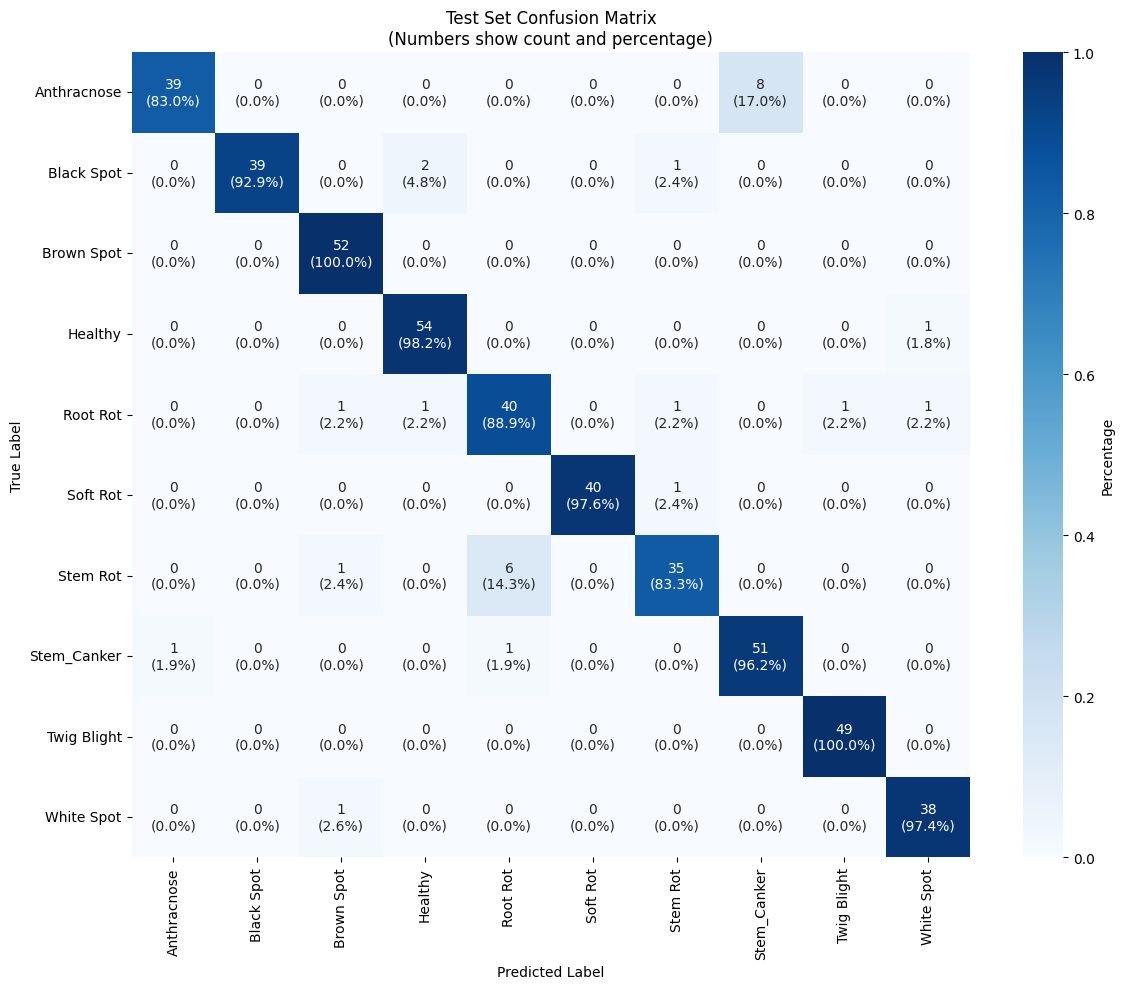


=== CONFUSION MATRIX FOR VALIDATION SET ===


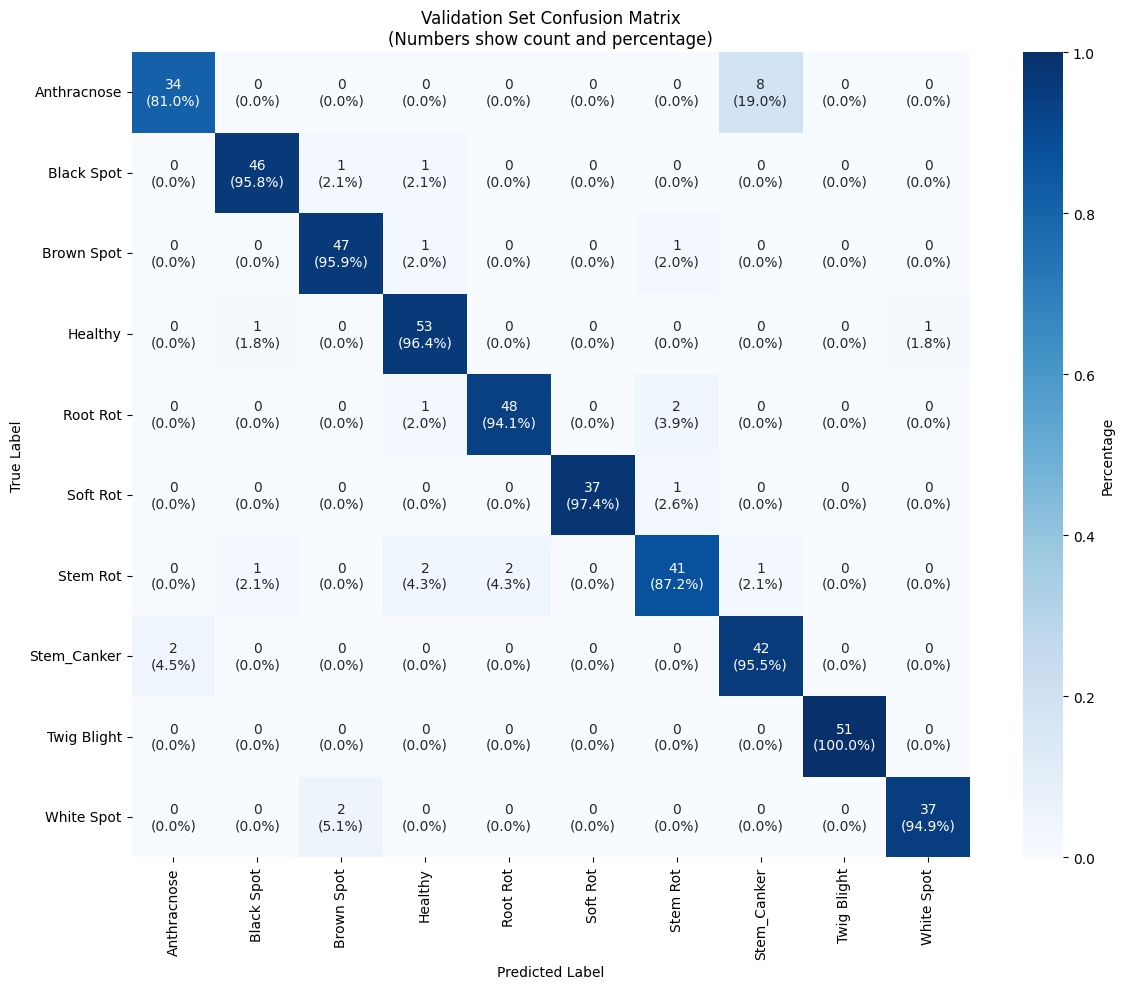

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os 

# Vẽ confusion matrix cho test set (quan trọng nhất)
print("=== CONFUSION MATRIX FOR TEST SET ===")
cm_test = plot_confusion_matrix_detailed(
    test_results['y_true'], 
    test_results['y_pred'], 
    full_dataset.classes, 
    title="Test Set Confusion Matrix"
)

# Vẽ confusion matrix cho validation set  
print("\n=== CONFUSION MATRIX FOR VALIDATION SET ===")
cm_val = plot_confusion_matrix_detailed(
    val_results['y_true'], 
    val_results['y_pred'], 
    full_dataset.classes, 
    title="Validation Set Confusion Matrix"
)

**Biểu đồ Debug**

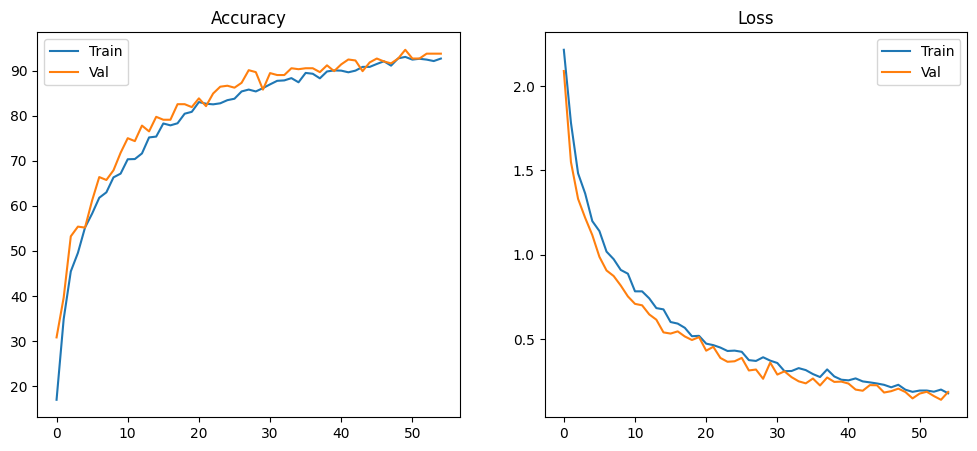

In [18]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(train_acc_l)
ax[0].plot(val_acc_l)
ax[0].legend(['Train', 'Val'])
ax[0].set_title("Accuracy")

ax[1].plot(train_loss_l)
ax[1].plot(val_loss_l)
ax[1].legend(['Train', 'Val'])
ax[1].set_title("Loss")

plt.show()

**Smoothing Loss and Acc**

Text(0.5, 1.0, 'Loss')

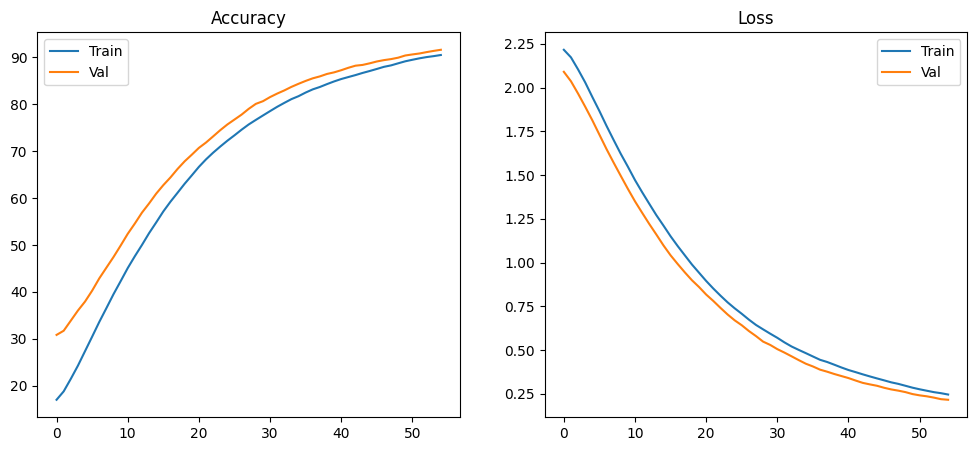

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.9):
    smoothed = []
    last = points[0]
    for point in points:
        smoothed_val = last * factor + (1 - factor) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

train_acc_smoothed = smooth_curve(train_acc_l)
val_acc_smoothed = smooth_curve(val_acc_l)
train_loss_smoothed = smooth_curve(train_loss_l)
val_loss_smoothed = smooth_curve(val_loss_l)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(train_acc_smoothed)
ax[0].plot(val_acc_smoothed)
ax[0].legend(['Train', 'Val'])
ax[0].set_title("Accuracy")

ax[1].plot(train_loss_smoothed)
ax[1].plot(val_loss_smoothed)
ax[1].legend(['Train', 'Val'])
ax[1].set_title("Loss")